# Extraction des données

In [9]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

targets = []
features = []


##Jeu de données : https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zi

files = glob.glob("train/*.jpg")
random.shuffle(files)

for f in files[:1000]:
    features.append(np.array(Image.open(f).resize((200, 200))))
    target = [1, 0] if "cat" in f else [0, 1]
    targets.append(target)
    
features = np.array(features)
targets = np.array(targets)

print(features.shape)
print(targets.shape)

(1000, 200, 200, 3)
(1000, 2)


# Visualisation des images

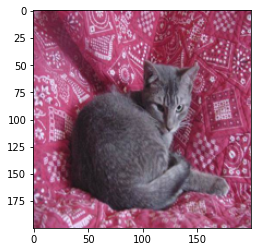

In [10]:
from random import randint

for a in [randint(0, len(targets)) for _ in range(10)]:
    plt.imshow(features[a])
    plt.show

# Mise en place du jeu d'entrainement et de validation

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(features, targets, test_size = 0.1, random_state = 42)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)


(900, 200, 200, 3)
(100, 200, 200, 3)
(900, 2)
(100, 2)


# Mise en place du modèle

In [16]:
##import tensorflow.compat.v1 as tf
##tf.disable_v2_behavior() 
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

##from tensorflow.keras.layers import flatten

# Entrées du graph
x = tf.compat.v1.placeholder(tf.float32, (None, 200, 200, 3), name = "Image")
y = tf.compat.v1.placeholder(tf.float32, (None, 2), name = "Targets")

def create_conv(prev, filter_size, nb):
    W_filters = tf.Variable(tf.random.truncated_normal(shape=(filter_size, filter_size, int(prev.get_shape()[-1]), nb)))
    b_filters = tf.Variable(tf.zeros(shape=(nb)))
    conv = tf.nn.conv2d(prev, W_filters, strides=[1,1,1,1], padding="SAME") + b_filters
    conv = tf.nn.relu(conv)
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    
    return conv
    
conv = create_conv(x, 10, 32)
conv = create_conv(conv, 8, 64)
conv = create_conv(conv, 8, 124)
conv = create_conv(conv, 8, 256)
conv = create_conv(conv, 8, 512)

flat = tf.keras.layers.Flatten()(conv)

# Layer entierement connecté
w1 = tf.Variable(tf.random.truncated_normal(shape=(int(flat.get_shape()[1]), 521)))
b1 = tf.Variable(tf.zeros(shape=(521)))

fc1 = tf.matmul(flat, w1) + b1
fc1 = tf.nn.relu(fc1)

# Layer entierement connecté en sortie
w2 = tf.Variable(tf.random.truncated_normal(shape=(521, 2)))
b2 = tf.Variable(tf.zeros(shape=(2)))

logits = tf.matmul(fc1, w2) + b2

softmax = tf.nn.softmax(logits)


# Erreur et optimisation

In [17]:
# Estimation de l'erreur
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss_operation = tf.reduce_mean(cross_entropy)


# Precision des estimations
correct_prediction = tf.equal(tf.argmax(softmax, axis=1), tf.argmax(y, axis = 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Optimisation
optimizer = tf.compat.v1.train.AdamOptimizer(0.001)
train_op = optimizer.minimize(loss_operation) 


# Entrainement du modèle

In [18]:
batch_size = 200

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

for epochs in range (0, 1):
    index = np.arange(len(X_train))
    np.random.shuffle(index)
    X_train = X_train[index]
    Y_train = Y_train[index]
    
    for b in range (0, len(X_train), batch_size):
        print("b = %s, %s" % (b, len(X_train)))
        batch = X_train[b: b+batch_size]
        sess.run(train_op, feed_dict = {x: batch, y: Y_train[b: b+batch_size]})
        
    accs = []
    
    for b in range (0, len(X_valid), batch_size):
        batch = X_valid[b: b+batch_size]
        acc = sess.run(accuracy, feed_dict = {x: batch, y: Y_valid[b: b+batch_size]})    
        accs.append(acc)
    
    print("Moyenne de valdiation", np.mean(accs))


b = 0, 900
b = 200, 900
b = 400, 900
b = 600, 900
b = 800, 900
Moyenne de valdiation 0.55


# Test image perso

(1, 2)
(1, 200, 200, 3)
Moyenne de valdiation 1.0


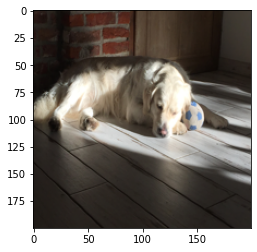

In [20]:
test_feature = []
test_target = []

test_file = glob.glob("test/*.jpg")

for f in test_file:
    test_feature.append(np.array(Image.open(f).resize((200, 200))))
    target = [0, 1]
    test_target.append(target)
    
test_target = np.array(test_target)
test_feature = np.array(test_feature)

print(test_target.shape)
print(test_feature.shape)

plt.imshow(test_feature[0])
plt.show

test_accs = []

test_batch = test_feature
test_acc = sess.run(accuracy, feed_dict = {x: test_batch, y: test_target})    
test_accs.append(test_acc)
##test_accs.append(1)


print("Moyenne de valdiation", np.mean(test_accs))

